# Independent Project: Correlation Analysis of the 2020 US Election - Turnout and Outcomes 

In my [previous](https://github.com/austenbrockman/projects/blob/main/Converting%20Election%20Data%20from%20NBC%20into%20a%20CSV%20File.ipynb) project, I converted the outcomes of the 2020 US Presidential Elections into a CSV file. I am now going to use this data in analyzing the voter turnout by state. 

My election outcomes table contains information about Donald Trump and Joe Biden's vote count in each state and Washington DC. The [turnout](https://www.kaggle.com/ayushggarg/us-election-turnout-eda) table contains information about the voter turnout in each state, along with counts of certain groups that are ineligible to vote. 

My objective is to determine if and how the measures in the turnout table correlate to the results of the election.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr 
turnout = pd.read_csv('/Users/Austen/Downloads/2020 November General Election - Turnout Rates.csv')
results = pd.read_csv('/Users/Austen/Desktop/python/NBC 2020 US Presidential Results.csv')

## Part 1: Data Cleaning 

For the turnout file, I removed all columns that had nulls. Not only were they missing several datapoints, they also contained information irrelevant to this analysis. The 'Vote for Highest Office (President)' in particular is redundant, because that information is captured in more detail in the results table. I also dropped the State Abbreviation column, since this information is redundant. I also dropped the row 'United States', since it contains aggregate data I can re-calculate if necessary.

All columns started as object dtype, so I then cleaned the applicable columns into numeric dtypes - integer for vote count, and float for percentages. For consistency with the results table, I also converted the percentages into ratios.

Because I had already cleaned the data in the results file in my previous project, the only cleaning I had to do was drop the URL column, which I don't need for this project.

In [2]:
turnout.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 15 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   State                                52 non-null     object
 1   Source                               40 non-null     object
 2   Official/Unofficial                  25 non-null     object
 3   Total Ballots Counted (Estimate)     52 non-null     object
 4   Vote for Highest Office (President)  24 non-null     object
 5   VEP Turnout Rate                     52 non-null     object
 6   Voting-Eligible Population (VEP)     52 non-null     object
 7   Voting-Age Population (VAP)          52 non-null     object
 8   % Non-citizen                        52 non-null     object
 9   Prison                               52 non-null     object
 10  Probation                            52 non-null     object
 11  Parole                               52 non-nul

In [3]:
turnout.head()

,State,Source,Official/Unofficial,Total Ballots Counted (Estimate),Vote for Highest Office (President),VEP Turnout Rate,Voting-Eligible Population (VEP),Voting-Age Population (VAP),% Non-citizen,Prison,Probation,Parole,Total Ineligible Felon,Overseas Eligible,State Abv
0,United States,NaN,NaN,"158,835,004",NaN,66.4%,"239,247,182","257,605,088",7.8%,"1,461,074","1,962,811","616,440","3,294,457","4,971,025",NaN
1,Alabama,https://www2.alabamavotes.gov/electionnight/st...,Unofficial,"2,306,587","2,297,295",62.6%,"3,683,055","3,837,540",2.3%,"25,898","50,997","10,266","67,782",NaN,AL
2,Alaska,https://www.elections.alaska.gov/results/20GEN...,NaN,"367,000",NaN,69.8%,"525,568","551,117",3.4%,"4,293","2,074","1,348","6,927",NaN,AK
3,Arizona,https://results.arizona.vote/#/featured/18/0,NaN,"3,400,000",NaN,65.5%,"5,189,000","5,798,473",8.9%,"38,520","76,844","7,536","93,699",NaN,AZ
4,Arkansas,https://results.enr.clarityelections.com/AR/10...,Unofficial,"1,212,030","1,206,697",55.5%,"2,182,375","2,331,171",3.6%,"17,510","36,719","24,698","64,974",NaN,AR


In [4]:
turnout = turnout.drop(columns = ['Source', 'Official/Unofficial','Vote for Highest Office (President)','Overseas Eligible','State Abv'], index = 0)
turnout.reset_index(drop=True,inplace = True,)

In [5]:
results.head()

,State,Electoral Votes,URL,Biden Vote Share,Biden Vote Count,Trump Vote Share,Trump Vote Count
0,Alabama,9,https://www.nbcnews.com/politics/2020-election...,0.366,849648,0.620,1441168
1,Alaska,3,https://www.nbcnews.com/politics/2020-election...,0.428,153778,0.528,189951
2,Arizona,11,https://www.nbcnews.com/politics/2020-election...,0.494,1672143,0.491,1661686
3,Arkansas,6,https://www.nbcnews.com/politics/2020-election...,0.348,423932,0.624,760647
4,California,55,https://www.nbcnews.com/politics/2020-election...,0.635,11109764,0.343,6005961


In [6]:
results = results.drop(columns = ['URL','Electoral Votes'])

In [7]:
percent_cols = ['VEP Turnout Rate','% Non-citizen',]
def clean_percent(item): 
    item = item.replace('%',"")
    item = float(item)
    item = item/100 
    return item
for col in percent_cols: 
    turnout[col] = turnout[col].apply(clean_percent)

count_cols = ['Total Ballots Counted (Estimate)','Voting-Eligible Population (VEP)','Voting-Age Population (VAP)',
             'Prison','Probation','Parole', 'Total Ineligible Felon']
def clean_count(item):
    item = item.replace(',',"")
    item = int(item)
    return item
for col in count_cols: 
    turnout[col] = turnout[col].apply(clean_count)
turnout.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 10 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   State                             51 non-null     object 
 1   Total Ballots Counted (Estimate)  51 non-null     int64  
 2   VEP Turnout Rate                  51 non-null     float64
 3   Voting-Eligible Population (VEP)  51 non-null     int64  
 4   Voting-Age Population (VAP)       51 non-null     int64  
 5   % Non-citizen                     51 non-null     float64
 6   Prison                            51 non-null     int64  
 7   Probation                         51 non-null     int64  
 8   Parole                            51 non-null     int64  
 9   Total Ineligible Felon            51 non-null     int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 4.1+ KB


In [8]:
turnout.head()

,State,Total Ballots Counted (Estimate),VEP Turnout Rate,Voting-Eligible Population (VEP),Voting-Age Population (VAP),% Non-citizen,Prison,Probation,Parole,Total Ineligible Felon
0,Alabama,2306587,0.626,3683055,3837540,0.023,25898,50997,10266,67782
1,Alaska,367000,0.698,525568,551117,0.034,4293,2074,1348,6927
2,Arizona,3400000,0.655,5189000,5798473,0.089,38520,76844,7536,93699
3,Arkansas,1212030,0.555,2182375,2331171,0.036,17510,36719,24698,64974
4,California,16800000,0.647,25962648,30783255,0.150,104730,0,102586,207316


### 1.1: Merging Data and Verifying Quality

Once the data was in a consistent format, I joined the tables and begin exploring the data. I created a function to check the minimum and maximum values for all of the columns, to ensure that the data was in an expected range. The data appeared sound, with the exception that some of the values in the percentage columns had a large number of decimal places. I rounded all of the data in these columns to three decimal places.

In [9]:
merge = pd.merge(left = turnout, right = results, on = 'State')
merge.head(5)
# note that the total ballots counted is more than the sum of Biden or Trump's votes, due to third-party candidates and 
# voters who didn't cast a vote for President.

,State,Total Ballots Counted (Estimate),VEP Turnout Rate,Voting-Eligible Population (VEP),Voting-Age Population (VAP),% Non-citizen,Prison,Probation,Parole,Total Ineligible Felon,Biden Vote Share,Biden Vote Count,Trump Vote Share,Trump Vote Count
0,Alabama,2306587,0.626,3683055,3837540,0.023,25898,50997,10266,67782,0.366,849648,0.620,1441168
1,Alaska,367000,0.698,525568,551117,0.034,4293,2074,1348,6927,0.428,153778,0.528,189951
2,Arizona,3400000,0.655,5189000,5798473,0.089,38520,76844,7536,93699,0.494,1672143,0.491,1661686
3,Arkansas,1212030,0.555,2182375,2331171,0.036,17510,36719,24698,64974,0.348,423932,0.624,760647
4,California,16800000,0.647,25962648,30783255,0.150,104730,0,102586,207316,0.635,11109764,0.343,6005961


In [10]:
min_max = []
def min_max(df): 
    min_max = []
    for col in df: 
        val1 = col 
        val2 = min(df[col])
        val3 = max(df[col])
        min_max.append([val1,val2,val3])
    return min_max
        
print(min_max(merge))

[['State', 'Alabama', 'Wyoming'], ['Total Ballots Counted (Estimate)', 278503, 16800000], ['VEP Turnout Rate', 0.55, 0.799], ['Voting-Eligible Population (VEP)', 431364, 25962648], ['Voting-Age Population (VAP)', 447915, 30783255], ['% Non-citizen', 0.009000000000000001, 0.15], ['Prison', 0, 154913], ['Probation', 0, 416771], ['Parole', 0, 109213], ['Total Ineligible Felon', 0, 492390], ['Biden Vote Share', 0.266, 0.921], ['Biden Vote Count', 73491, 11109764], ['Trump Vote Share', 0.054000000000000006, 0.6990000000000001], ['Trump Vote Count', 18586, 6005961]]


In [11]:
percent_cols = ['VEP Turnout Rate','% Non-citizen','Trump Vote Share','Biden Vote Share']
for col in percent_cols: 
    merge[col] = merge[col].apply(lambda i: round(i,3))
print(min_max(merge[percent_cols]))

[['VEP Turnout Rate', 0.55, 0.799], ['% Non-citizen', 0.009, 0.15], ['Trump Vote Share', 0.054, 0.699], ['Biden Vote Share', 0.266, 0.921]]


## Part 2: Correlation Analysis 

After the data has been cleaned and organized, I examined correlation between variables. Because the states vary widely in their population counts, I'm only going to use percentage columns in my analysis. I made an exception when including the total population size of each state, because normalizing the data into a ratio format would yield the same values for the correlation and p-value as keeping the raw number. 

I first added to add some additional measures to my table: <br>
1) VEP/VAP -  the ratio of the voting-age population that is eligible to vote. <br>
2) The percentage of the VAP ineligible due to a criminal record.<br>
3) A binary variable signifying if Biden or Trump won the state. A positive correlation for Biden is a negative correlation for Trump, since this measure is binary.

Then, I constructed a heatmap of correlation between all variables. I used Pearson's correlation to examine linear correlation. With this measure, 1 is a direct positive correlation and -1 is a direct negative correlation, with 0 being no correlation. I noticed certain correlations in the heatmap, so I verified them using the p-value. 

In [12]:
merge['VEP/VAP'] = round(merge['Voting-Eligible Population (VEP)']/merge['Voting-Age Population (VAP)'],3)
merge['% Felon'] =round(merge['Total Ineligible Felon']/merge['Voting-Age Population (VAP)'],3)
print(min_max(merge[['VEP/VAP','% Felon']]))

[['VEP/VAP', 0.843, 0.983], ['% Felon', 0.0, 0.04]]


In [13]:
merge['Biden Win'] = np.where(merge['Biden Vote Share']>merge['Trump Vote Share'], 1, 0)
merge.head()

,State,Total Ballots Counted (Estimate),VEP Turnout Rate,Voting-Eligible Population (VEP),Voting-Age Population (VAP),% Non-citizen,Prison,Probation,Parole,Total Ineligible Felon,Biden Vote Share,Biden Vote Count,Trump Vote Share,Trump Vote Count,VEP/VAP,% Felon,Biden Win
0,Alabama,2306587,0.626,3683055,3837540,0.023,25898,50997,10266,67782,0.366,849648,0.620,1441168,0.960,0.018,0
1,Alaska,367000,0.698,525568,551117,0.034,4293,2074,1348,6927,0.428,153778,0.528,189951,0.954,0.013,0
2,Arizona,3400000,0.655,5189000,5798473,0.089,38520,76844,7536,93699,0.494,1672143,0.491,1661686,0.895,0.016,1
3,Arkansas,1212030,0.555,2182375,2331171,0.036,17510,36719,24698,64974,0.348,423932,0.624,760647,0.936,0.028,0
4,California,16800000,0.647,25962648,30783255,0.150,104730,0,102586,207316,0.635,11109764,0.343,6005961,0.843,0.007,1


In [14]:
corr_measures = merge[['State', 'VEP Turnout Rate', '% Non-citizen','Biden Vote Share','Trump Vote Share','VEP/VAP','% Felon','Voting-Age Population (VAP)','Biden Win',]]
corr_measures.head()

,State,VEP Turnout Rate,% Non-citizen,Biden Vote Share,Trump Vote Share,VEP/VAP,% Felon,Voting-Age Population (VAP),Biden Win
0,Alabama,0.626,0.023,0.366,0.620,0.960,0.018,3837540,0
1,Alaska,0.698,0.034,0.428,0.528,0.954,0.013,551117,0
2,Arizona,0.655,0.089,0.494,0.491,0.895,0.016,5798473,1
3,Arkansas,0.555,0.036,0.348,0.624,0.936,0.028,2331171,0
4,California,0.647,0.150,0.635,0.343,0.843,0.007,30783255,1


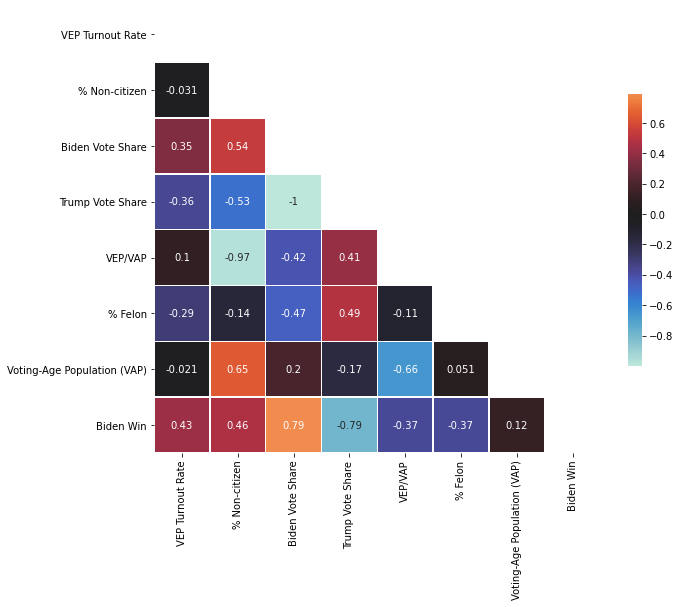

In [15]:
df_temp = corr_measures.set_index('State')
corr = df_temp.corr(method = 'pearson')
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(10,10))
sns.heatmap(corr, mask=mask, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

### 2.1 Observations of voting trends:
1) Correlation between VEP turnout rate and vote share/state winner: positive for Biden, negative for Trump. <br>
2) Correlation between % non-citizen and vote share/state winner: positive for Biden, negative for Trump. <br>
3) Weak correlation between VAP and vote share/state winner: positive for Biden, negative for Trump. <br>
4) Correlation between % Felon and vote share/state winner: positive for Trump, negative for Biden. <br> 
5) Correlation between VEP/VAP and vote share/state winner: positive for Trump, negative for Biden. <br>
6) The turnout measures correlate to the winner of the state in the same way that they do to each candidates' vote share.

Before making any conclusions, I need to substantiate my observations by determining which are statistically significant.

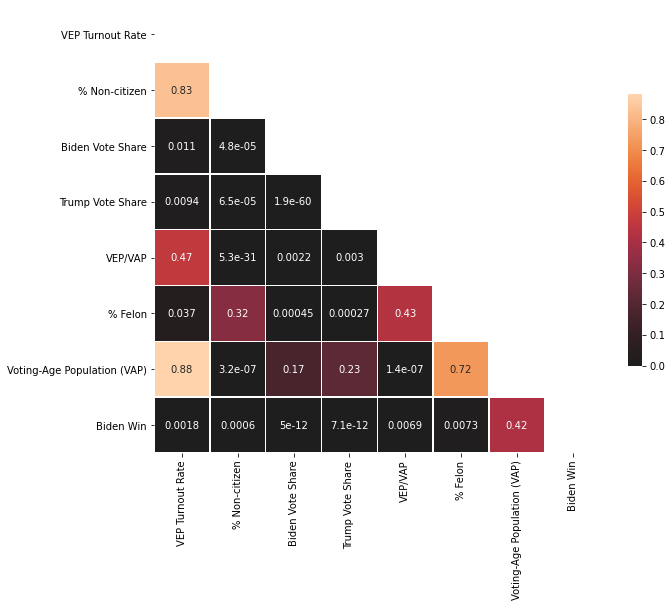

In [16]:
p_values = corr_measures.corr(method=lambda x, y: pearsonr(x, y)[1])
plt.figure(figsize=(10,10))
sns.heatmap(p_values, mask=mask, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

### Which observations are significant? 
*I am using the metric p < 0.05 to determine significance. <br>*

1) Correlation between VEP turnout rate and vote share/state winner: positive for Biden, negative for Trump: **significant** <br>
2) Correlation between % non-citizen and vote share/state winner: positive for Biden, negative for Trump: **significant** <br>
3) Weak correlation between VAP and vote share/state winner: positive for Biden, negative for Trump: **not significant**<br>
4) Correlation between % Felon and vote share/state winner: positive for Trump, negative for Biden: **significant** <br> 
5) Correlation between VEP/VAP and vote share/state winner: positive for Trump, negative for Biden: **significant**


## Part 3: Analysis of Results 

To sum it up, Biden had a higher vote share - and was more likely to win - in states with higher VEP turnout rate, and a higher % of non-citizens. Trump had a higher vote share and was more likely to win states with a higher share of felons and a higher VEP/VAP, meaning more people eligile to vote amongst the voting-aged population. 

The VEP/VAP ratio is determined by two factors: % non-citizens and % felons. Why is the %Felons and VEP/VAP positively correlated with Trump's vote share, but non-citizens correlated with Biden's? 

I dug deeper into the % Felon and % non-citizen measures by looking at min/max values, histograms, and Pearson correlations of each to the total percentage of non-eligible voting-age population. 

In [17]:
merge['Non-eligible VAP'] = merge['% Non-citizen']+merge['% Felon']
print(min_max(merge[['% Non-citizen','% Felon','Non-eligible VAP',]]))

[['% Non-citizen', 0.009, 0.15], ['% Felon', 0.0, 0.04], ['Non-eligible VAP', 0.016, 0.157]]


(array([ 9., 14.,  6.,  7.,  8.,  4.,  1.,  1.,  0.,  1.]),
 array([0.   , 0.004, 0.008, 0.012, 0.016, 0.02 , 0.024, 0.028, 0.032,
        0.036, 0.04 ]),
 <a list of 10 Patch objects>)

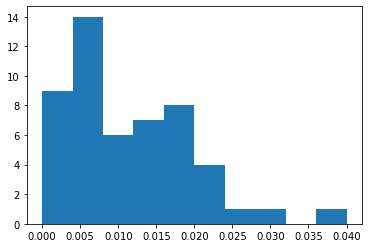

In [18]:
plt.hist(merge['% Felon'])

(array([23., 17.,  9.,  2.]),
 array([0.  , 0.04, 0.08, 0.12, 0.16]),
 <a list of 4 Patch objects>)

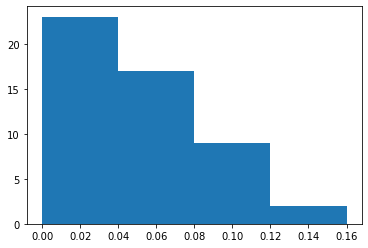

In [19]:
plt.hist(merge['% Non-citizen'], bins = (0,0.04,0.08,0.12,0.16))

(array([ 4., 11.,  7., 12.,  5.,  3.,  6.,  1.,  0.,  2.]),
 array([0.016 , 0.0301, 0.0442, 0.0583, 0.0724, 0.0865, 0.1006, 0.1147,
        0.1288, 0.1429, 0.157 ]),
 <a list of 10 Patch objects>)

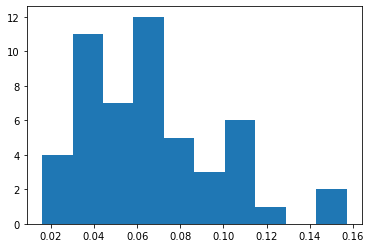

In [20]:
plt.hist(merge['Non-eligible VAP'])

In [21]:
print(merge.sort_values(by ='% Non-citizen',ascending=False).head(10))

            State  Total Ballots Counted (Estimate)  VEP Turnout Rate  \
4      California                          16800000             0.647   
43          Texas                          11300000             0.602   
28         Nevada                           1370000             0.636   
30     New Jersey                           4495000             0.730   
32       New York                           8930000             0.653   
9         Florida                          11150000             0.717   
11         Hawaii                            579165             0.575   
47     Washington                           4100000             0.754   
2         Arizona                           3400000             0.655   
21  Massachusetts                           3725000             0.734   

    Voting-Eligible Population (VEP)  Voting-Age Population (VAP)  \
4                           25962648                     30783255   
43                          18784280                     2

In [22]:
print(merge.sort_values(by ='% Felon',ascending=False).head(10))

          State  Total Ballots Counted (Estimate)  VEP Turnout Rate  \
10      Georgia                           5025000             0.681   
3      Arkansas                           1212030             0.555   
12        Idaho                            875000             0.677   
18    Louisiana                           2155000             0.639   
43        Texas                          11300000             0.602   
17     Kentucky                           2150951             0.649   
24  Mississippi                           1330000             0.604   
7      Delaware                            507805             0.705   
0       Alabama                           2306587             0.626   
36     Oklahoma                           1565000             0.550   

    Voting-Eligible Population (VEP)  Voting-Age Population (VAP)  \
10                           7383562                      8255108   
3                            2182375                      2331171   
12         

In [23]:
x = merge['Non-eligible VAP'] 
y = merge['% Non-citizen']
z = merge['% Felon']

non_cit_corr = pearsonr(x,y)
print(non_cit_corr)

(0.9670910451720901, 8.739085907853572e-31)


In [24]:
felon_corr = pearsonr(x,z)
print(felon_corr)

(0.1157751141066013, 0.41849894566287593)


## Part 4: Conclusion 

Despite taking away from the VEP/VAP, an increase in ineligible felon population was positively correlated to votes for Donald Trump, who had more success where the VEP/VAP ratio was higher.

When I looked at the proportion of the felon population as a whole, no state had an ineligible prison population higher than 4%. Of the states with the ten highest populations of ineligible felons, Trump won eight. 

Conversely, the ratio of non-citizens, which was positively correlated to Biden winning, was higher than 4% in 26 states. One state, California, had 15%, and six states had populations of non-citizens above 10%. Of the ten states with the highest percentage of non-citizens, Biden won in eight. Of these states, the highest Felon population was 1.6%. 

Because the non-citizen populations tended to be much larger than the felon population, the total non-eligible percentage was strongly correlated to the non-citizen percentage, but not correlated to the felon percentage. Because the international population percentages were larger, and Biden won states with a higher non-citizen population, it makes sense that Trump wins were positively correlated by a higher VEP/VAP ratio. 

In summary, Biden's success was positively correlated with the VEP turnout, but Trump's success was positively correlated with a higher VEP/VAP ratio. This is because the VEP/VAP ratio is determined mostly by the percentage of non-citizens, and states with the highest non-citizen populations trended towards Biden. 

